In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [3]:
data = pd.read_csv('Avocado.csv', index_col='Unnamed: 0')
data

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
8,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
9,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico
10,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico


In [4]:
df = data[(data['region']=='Orlando') & (data['type']=='conventional')]
df

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,0.99,305773.54,211102.90,20765.29,124.04,73781.31,40641.55,33139.76,0.00,conventional,2015,Orlando
1,2015-12-20,1.21,200074.81,131152.60,15794.56,122.07,53005.58,36258.03,16747.55,0.00,conventional,2015,Orlando
2,2015-12-13,0.96,310101.52,217679.37,24260.86,168.63,67992.66,31407.15,36585.51,0.00,conventional,2015,Orlando
3,2015-12-06,1.20,199063.82,135222.96,21555.66,121.93,42163.27,24098.62,18064.65,0.00,conventional,2015,Orlando
4,2015-11-29,0.96,262683.80,190361.54,21007.77,37.82,51276.67,21536.82,29739.85,0.00,conventional,2015,Orlando
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,2018-02-04,0.99,759532.37,511953.91,60712.96,1345.00,185520.50,88148.10,97195.73,176.67,conventional,2018,Orlando
8,2018-01-28,1.35,414781.12,262391.05,28265.08,1290.40,122834.59,75243.30,47547.96,43.33,conventional,2018,Orlando
9,2018-01-21,1.16,482904.74,312991.46,36478.07,1521.70,131913.51,72049.51,59856.21,7.79,conventional,2018,Orlando
10,2018-01-14,1.40,387588.47,258150.99,26672.33,1199.66,101565.49,68412.96,33152.53,0.00,conventional,2018,Orlando


In [5]:
df.drop(columns= ["Small Bags", "Large Bags", "XLarge Bags"], axis = 1, inplace = True)

In [6]:
df.drop(columns=['type',"region"], axis = 1,inplace = True)

In [7]:
df

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,year
0,2015-12-27,0.99,305773.54,211102.90,20765.29,124.04,73781.31,2015
1,2015-12-20,1.21,200074.81,131152.60,15794.56,122.07,53005.58,2015
2,2015-12-13,0.96,310101.52,217679.37,24260.86,168.63,67992.66,2015
3,2015-12-06,1.20,199063.82,135222.96,21555.66,121.93,42163.27,2015
4,2015-11-29,0.96,262683.80,190361.54,21007.77,37.82,51276.67,2015
...,...,...,...,...,...,...,...,...
7,2018-02-04,0.99,759532.37,511953.91,60712.96,1345.00,185520.50,2018
8,2018-01-28,1.35,414781.12,262391.05,28265.08,1290.40,122834.59,2018
9,2018-01-21,1.16,482904.74,312991.46,36478.07,1521.70,131913.51,2018
10,2018-01-14,1.40,387588.47,258150.99,26672.33,1199.66,101565.49,2018


In [8]:
df["Total Volume"] = np.log(df['Total Volume'] + 1)

In [9]:
df

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,year
0,2015-12-27,0.99,12.630603,211102.90,20765.29,124.04,73781.31,2015
1,2015-12-20,1.21,12.206452,131152.60,15794.56,122.07,53005.58,2015
2,2015-12-13,0.96,12.644658,217679.37,24260.86,168.63,67992.66,2015
3,2015-12-06,1.20,12.201386,135222.96,21555.66,121.93,42163.27,2015
4,2015-11-29,0.96,12.478710,190361.54,21007.77,37.82,51276.67,2015
...,...,...,...,...,...,...,...,...
7,2018-02-04,0.99,13.540460,511953.91,60712.96,1345.00,185520.50,2018
8,2018-01-28,1.35,12.935509,262391.05,28265.08,1290.40,122834.59,2018
9,2018-01-21,1.16,13.087577,312991.46,36478.07,1521.70,131913.51,2018
10,2018-01-14,1.40,12.867702,258150.99,26672.33,1199.66,101565.49,2018


In [10]:
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
df = df.sort_index()

In [11]:
df

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,year
Date,,,,,,,
2015-01-04,1.00,12.548968,190743.27,38265.21,75.22,52719.49,2015
2015-01-11,1.29,12.216199,119336.02,39236.11,52.44,43410.02,2015
2015-01-18,1.33,12.160444,112722.12,34703.28,83.80,43569.17,2015
2015-01-25,1.28,12.264304,133616.30,29418.39,91.59,48864.81,2015
2015-02-01,0.95,13.100579,358731.15,50048.43,180.21,80264.72,2015
...,...,...,...,...,...,...,...
2018-02-25,1.30,12.940724,255777.62,26833.71,1404.42,132934.30,2018
2018-03-04,1.13,13.187593,331886.57,35297.07,1526.93,164990.41,2018
2018-03-11,1.13,13.179125,333909.79,33091.99,1477.79,160721.04,2018


In [12]:
df['day'] = df.index.day
df['month'] = df.index.month
df['seasonality'] = df['month'].apply(lambda x: 1 if x in [7, 8, 9] else 0)

In [13]:
df

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,year,day,month,seasonality
Date,,,,,,,,,,
2015-01-04,1.00,12.548968,190743.27,38265.21,75.22,52719.49,2015,4,1,0
2015-01-11,1.29,12.216199,119336.02,39236.11,52.44,43410.02,2015,11,1,0
2015-01-18,1.33,12.160444,112722.12,34703.28,83.80,43569.17,2015,18,1,0
2015-01-25,1.28,12.264304,133616.30,29418.39,91.59,48864.81,2015,25,1,0
2015-02-01,0.95,13.100579,358731.15,50048.43,180.21,80264.72,2015,1,2,0
...,...,...,...,...,...,...,...,...,...,...
2018-02-25,1.30,12.940724,255777.62,26833.71,1404.42,132934.30,2018,25,2,0
2018-03-04,1.13,13.187593,331886.57,35297.07,1526.93,164990.41,2018,4,3,0
2018-03-11,1.13,13.179125,333909.79,33091.99,1477.79,160721.04,2018,11,3,0


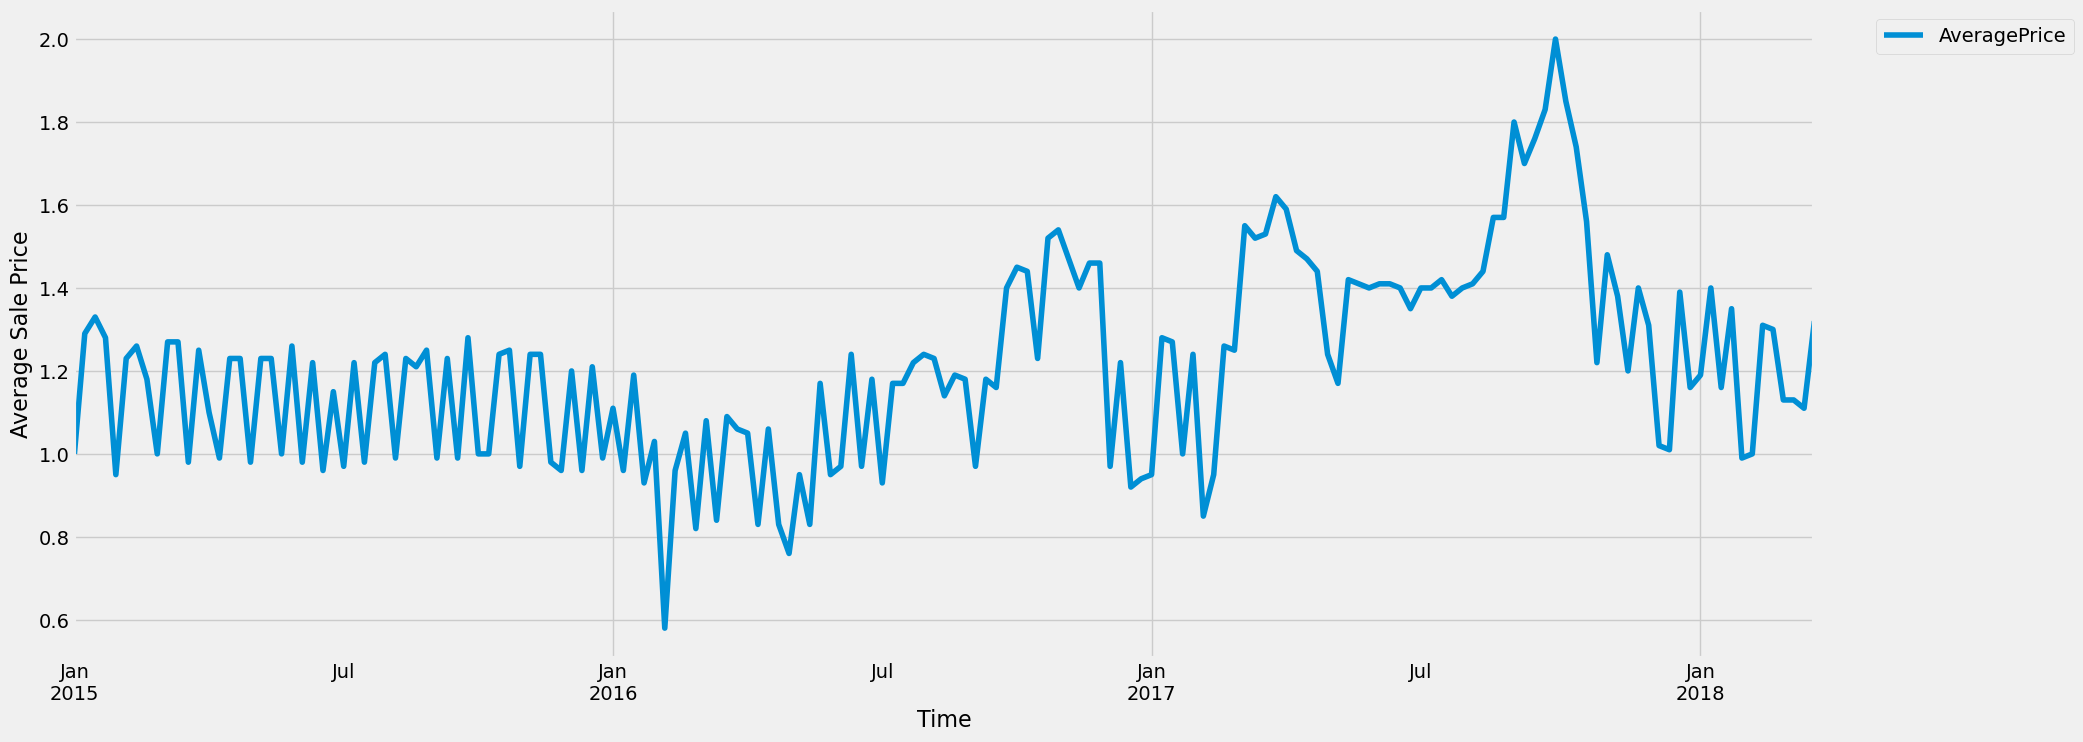

In [14]:
df["AveragePrice"].plot(figsize = (20,8))

plt.legend(bbox_to_anchor=(1.03,1), loc='upper left')
plt.xlabel("Time", fontsize = 16)
plt.ylabel("Average Sale Price", fontsize = 16)
plt.grid(True)
plt.show()

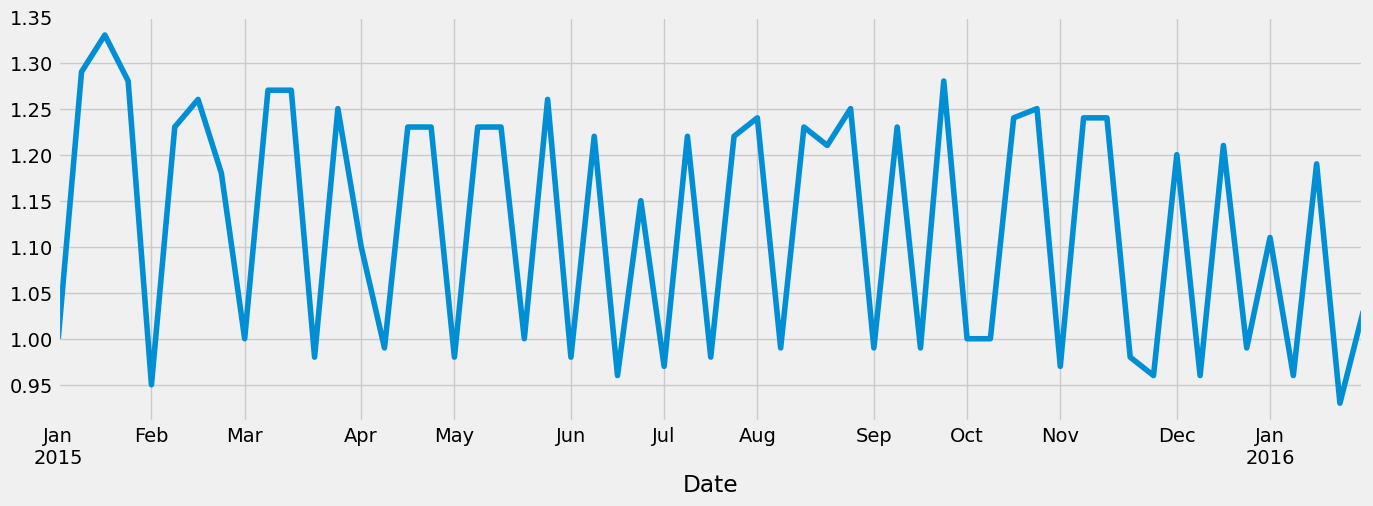

In [15]:
dff = df.loc[df.index < "02-01-2016"]
fig, ax = plt.subplots(figsize=(15, 5))
dff["AveragePrice"].plot(ax=ax, label='Training Set')
plt.show()


In [16]:
for i in range(8, 30):
    dff["lag_{}".format(i)] = dff.AveragePrice.shift(i)

In [17]:
dff.tail(7)

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,year,day,month,seasonality,...,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-20,1.21,12.206452,131152.60,15794.56,122.07,53005.58,2015,20,12,0,...,1.24,1.22,0.98,1.22,0.97,1.15,0.96,1.22,0.98,1.26
2015-12-27,0.99,12.630603,211102.90,20765.29,124.04,73781.31,2015,27,12,0,...,0.99,1.24,1.22,0.98,1.22,0.97,1.15,0.96,1.22,0.98
2016-01-03,1.11,12.640166,201918.77,31729.56,234.28,74829.12,2016,3,1,0,...,1.23,0.99,1.24,1.22,0.98,1.22,0.97,1.15,0.96,1.22
2016-01-10,0.96,12.932206,279393.48,31582.03,198.79,102239.28,2016,10,1,0,...,1.21,1.23,0.99,1.24,1.22,0.98,1.22,0.97,1.15,0.96
2016-01-17,1.19,12.421346,155452.86,21801.29,83.47,70701.54,2016,17,1,0,...,1.25,1.21,1.23,0.99,1.24,1.22,0.98,1.22,0.97,1.15
2016-01-24,0.93,12.898601,234746.69,54289.25,325.53,110390.17,2016,24,1,0,...,0.99,1.25,1.21,1.23,0.99,1.24,1.22,0.98,1.22,0.97
2016-01-31,1.03,12.705720,163156.69,61348.18,159.17,104962.88,2016,31,1,0,...,1.23,0.99,1.25,1.21,1.23,0.99,1.24,1.22,0.98,1.22


In [18]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit


In [19]:
tscv = TimeSeriesSplit(n_splits=5)

In [20]:
y = dff.dropna().AveragePrice
X = dff.dropna().drop(['AveragePrice'], axis=1)

In [21]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [22]:
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [24]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [26]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

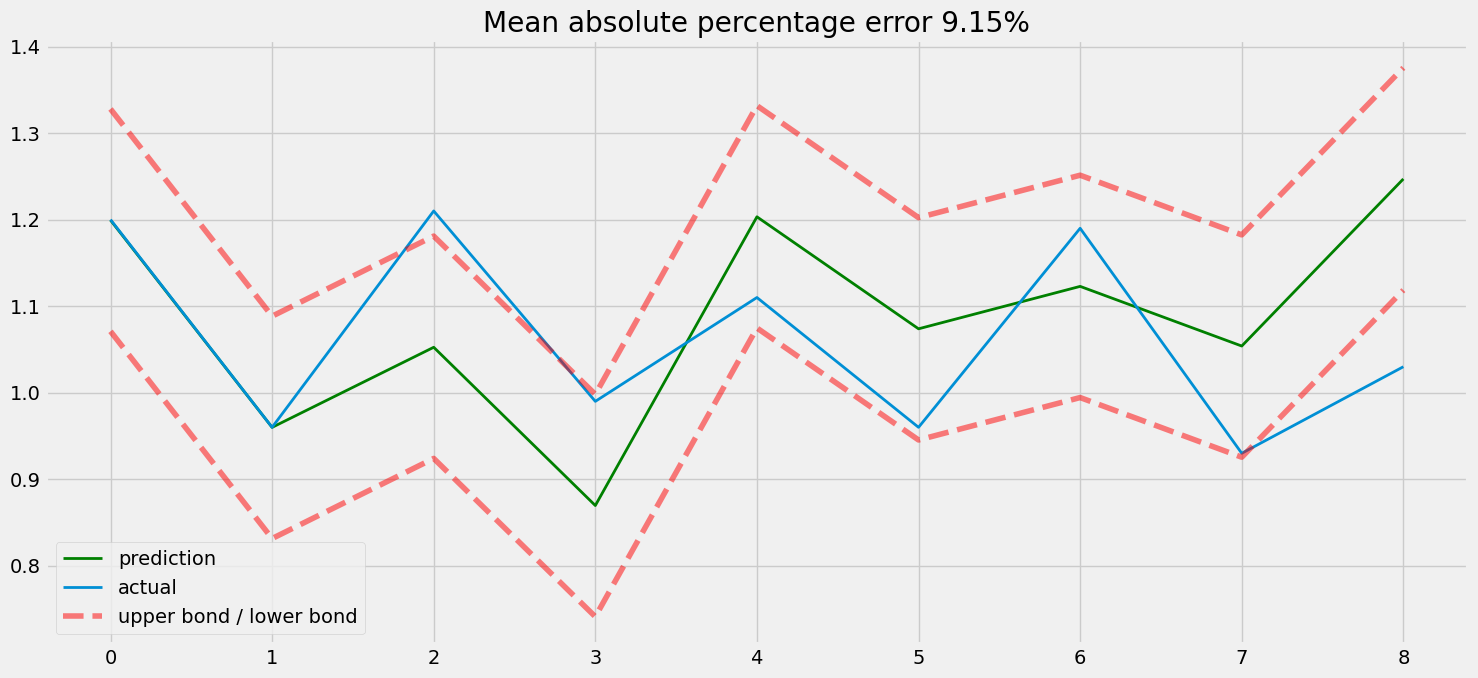

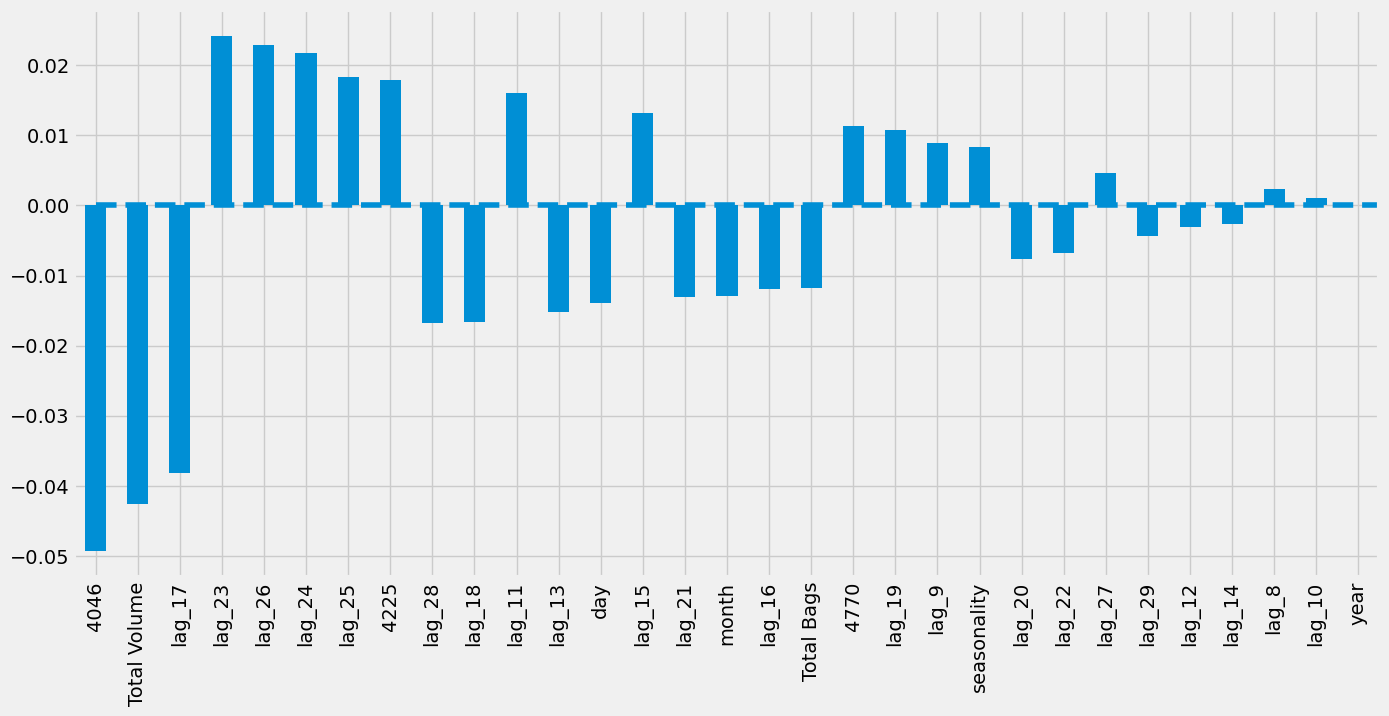

In [27]:
plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

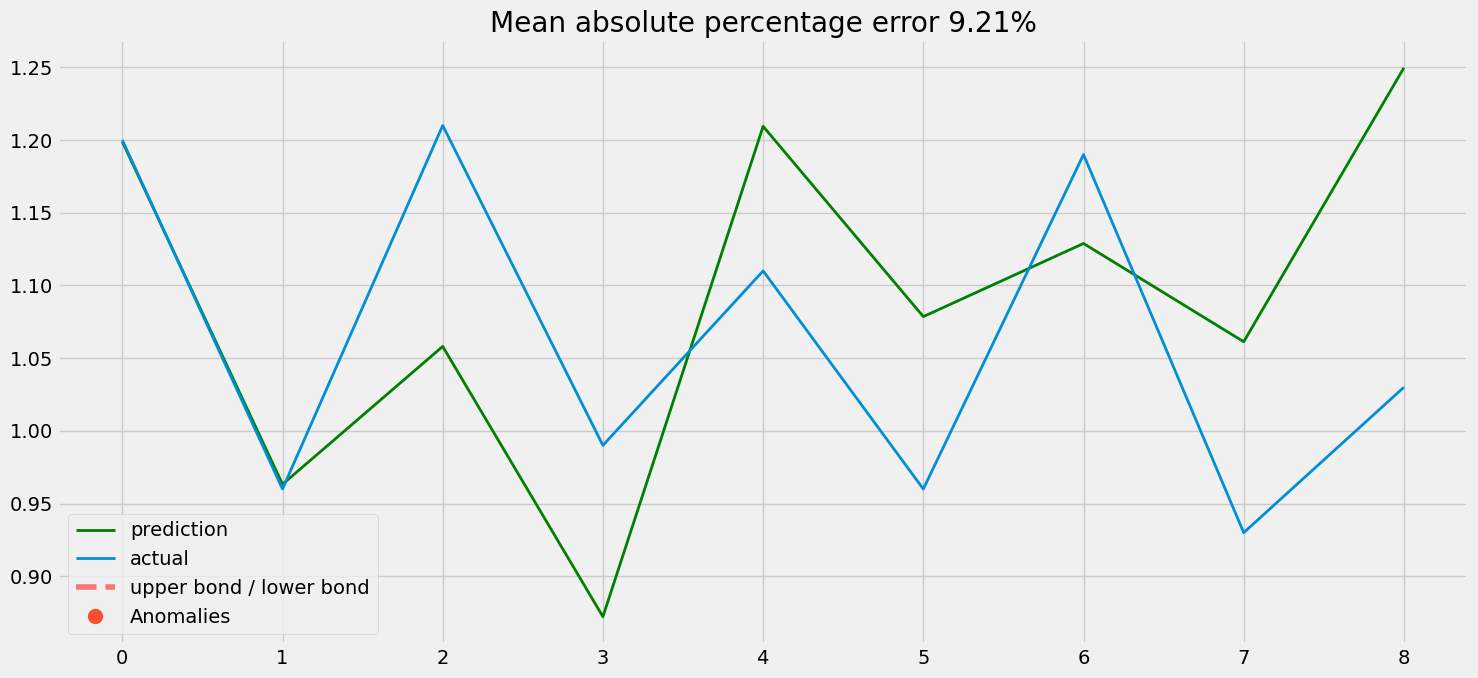

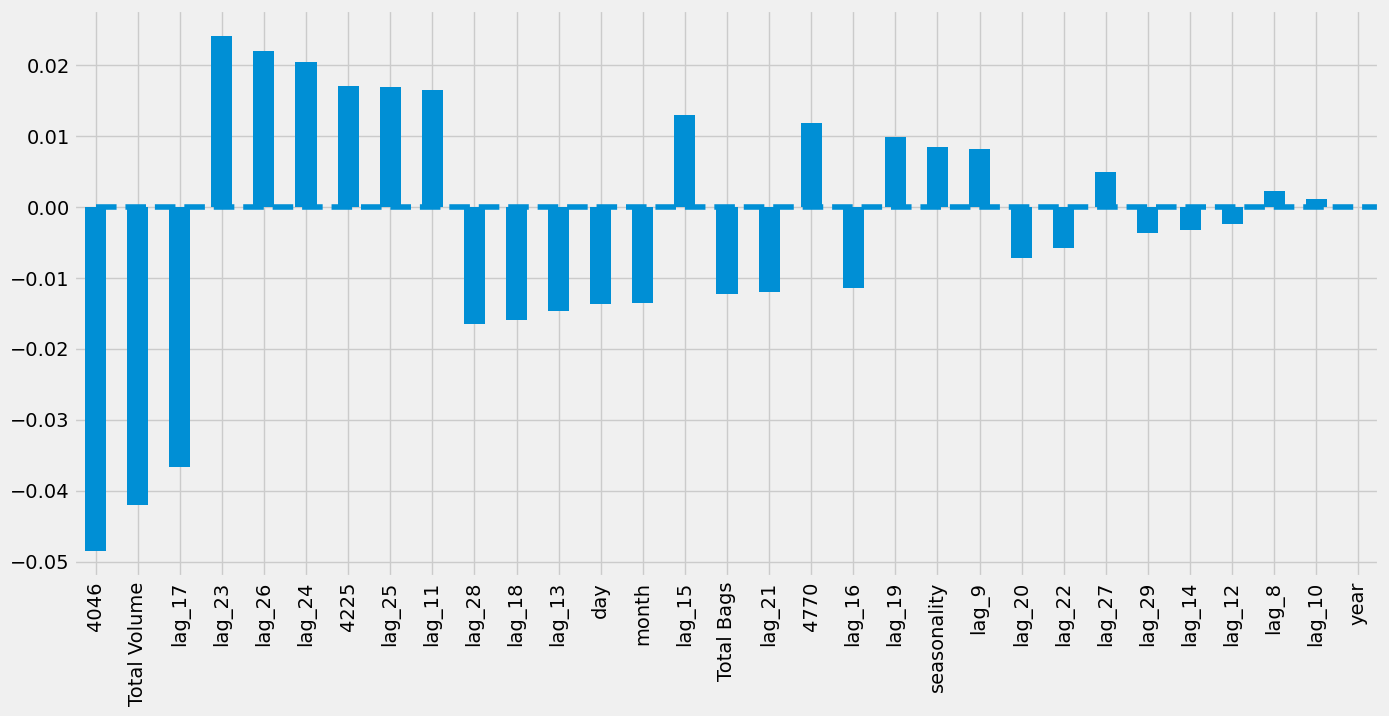

In [28]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

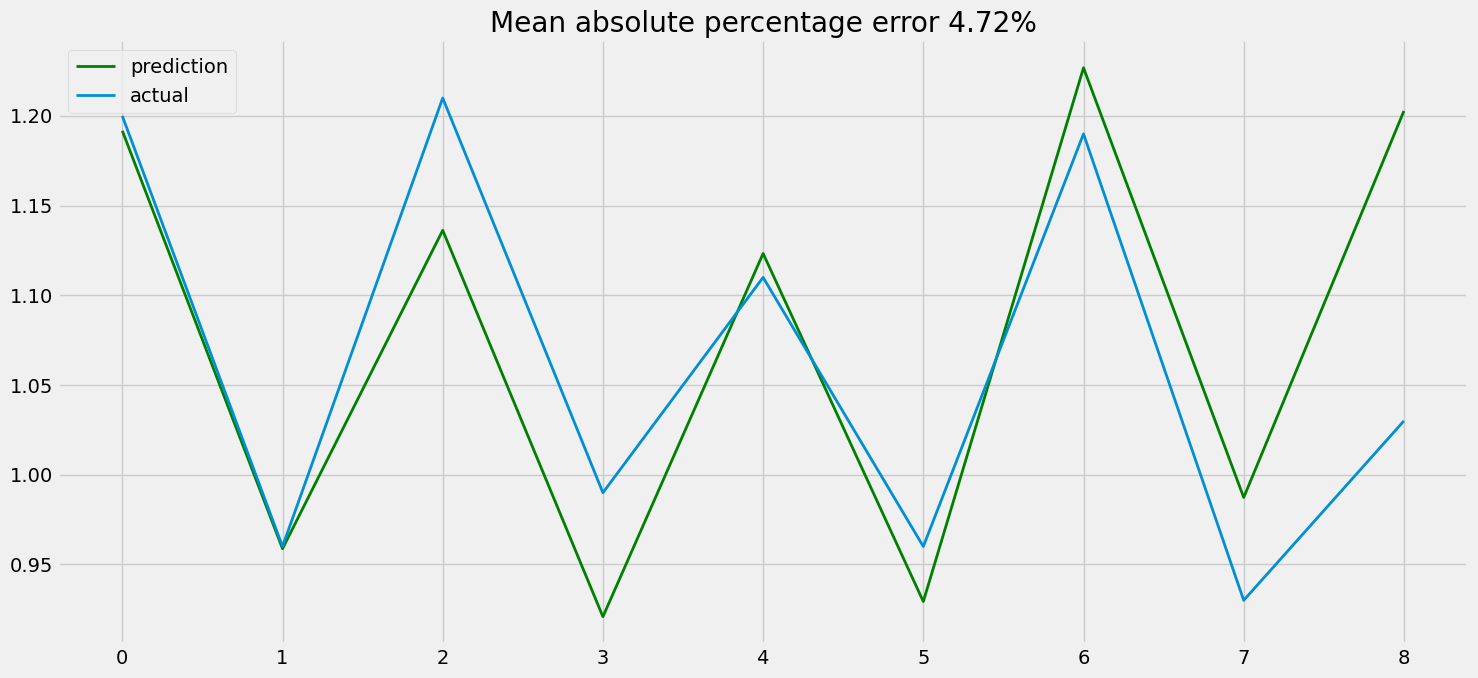

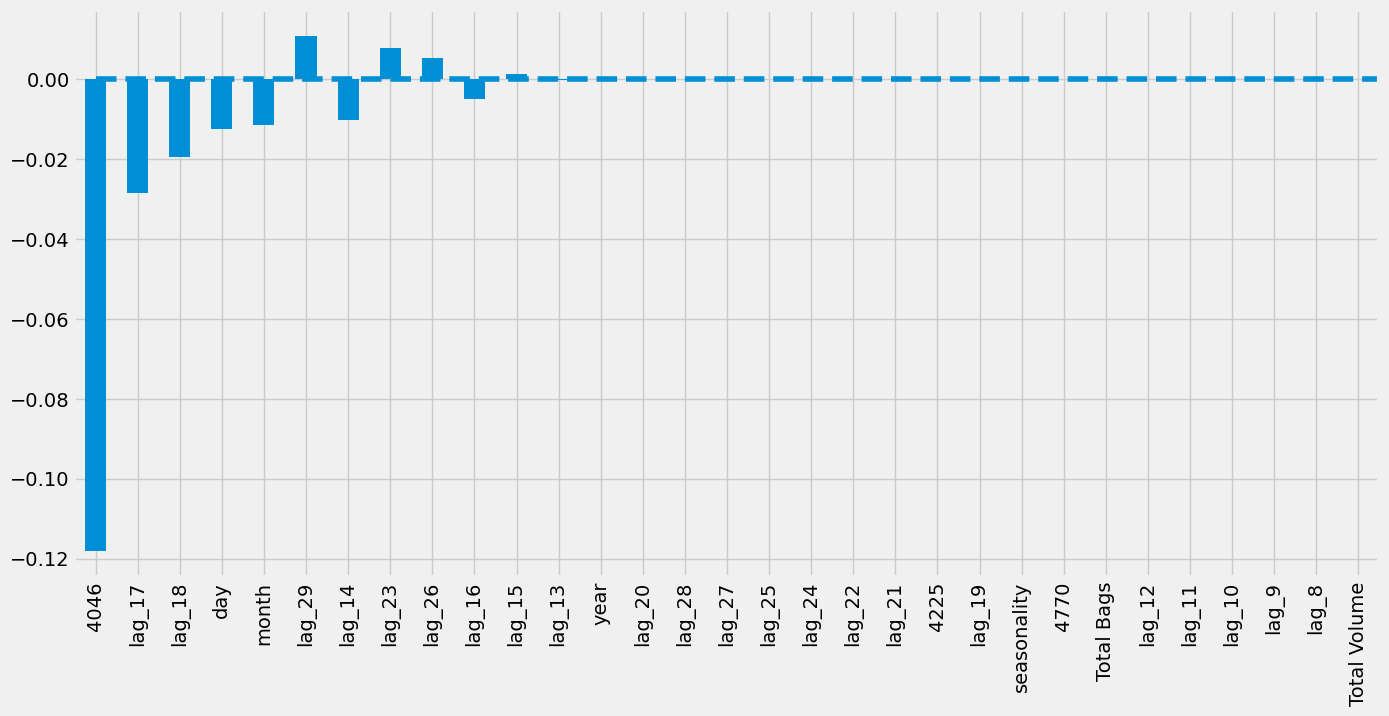

In [35]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=False, plot_anomalies=False)
plotCoefficients(lasso)

In [30]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

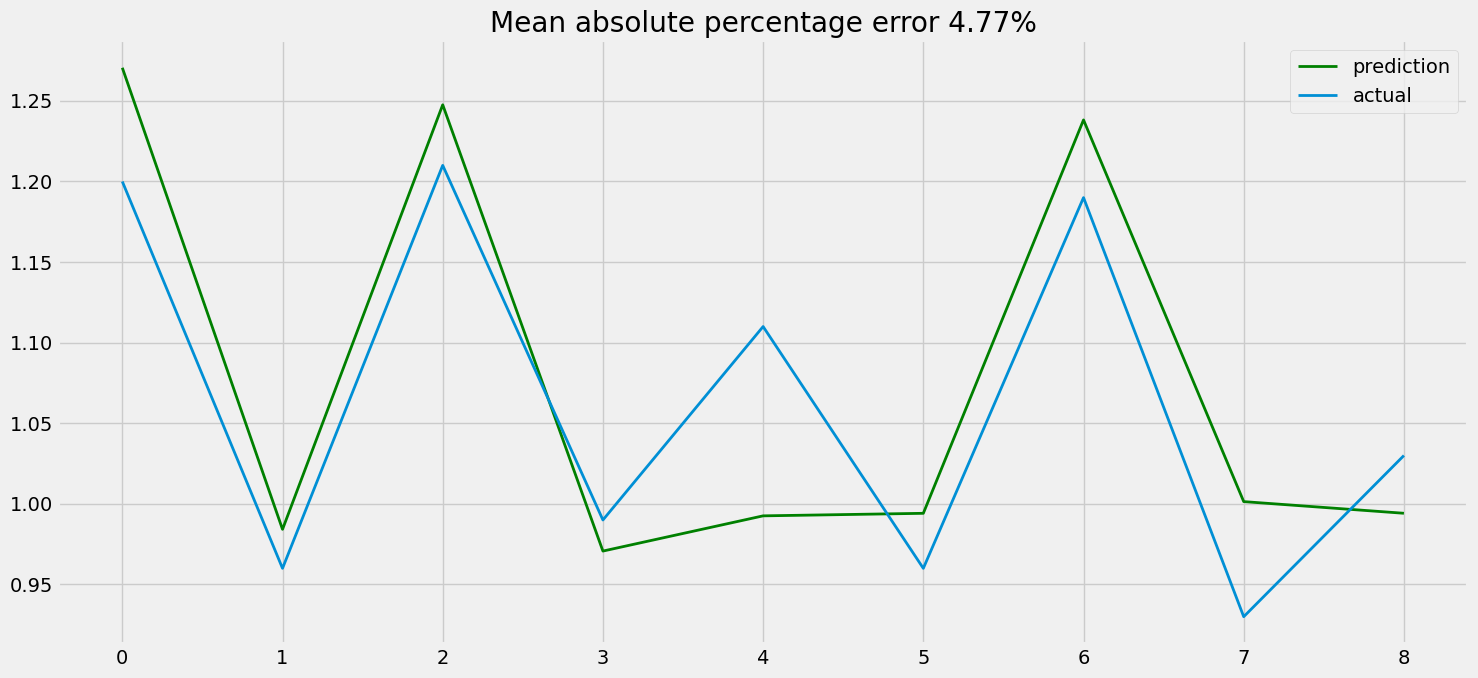

In [33]:
plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=False, plot_anomalies=True)